Nivell 1


Descàrrega els arxius CSV, estudia'ls i dissenya una base de dades amb un esquema d'estrella que contingui, almenys 4 taules


A) Creo la BBDD, schema transacciones
```
CREATE DATABASE transacciones;
```


B) Analizo los ficheros csv

1º las 3 tablas de users tenian el cursor en una linea vacia al final del fichero, he borrado esta ultima linea para poder posteriormente hacer un UNION.

2º    Creo las tablas (cada una con su tipo determinado en funcion del analisis del csv, teniendo en cuenta que las columnas que seran las fk/pk tengan el mismo tipo de dato)

```CREATE TABLE `transacciones`.`companies` (
  `company_id` VARCHAR(6) NOT NULL,
  `company_name` VARCHAR(45) NULL,
  `phone` VARCHAR(45) NULL,
  `email` VARCHAR(45) NULL,
  `country` VARCHAR(45) NULL,
  `website` VARCHAR(45) NULL,
  PRIMARY KEY (`company_id`),
  UNIQUE INDEX `company_id_UNIQUE` (`company_id` ASC) VISIBLE);
  ```

3º Uno las 3 tablas de users y creo la tabla users_total

```
    CREATE TABLE USERS_TOTAL AS
    SELECT * FROM USERS_USA
    UNION
    SELECT * FROM USERS_UK
    UNION
    SELECT * FROM USERS_CA;
    ```

4º a esta nueva tabla le genero la Primary Key y marco  que id sera unica.

```
ALTER TABLE `transacciones`.`users_total` 
ADD PRIMARY KEY (`id`),
ADD UNIQUE INDEX `id_UNIQUE` (`id` ASC) VISIBLE;
;
```

5º genero las relaciones FK-PK en la tabla transaction.


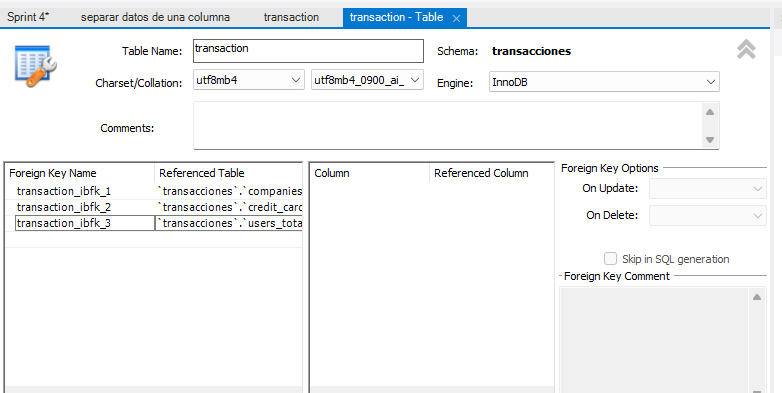

NOTA: DEJO LA RELACION DE LA TABLA PRODUCTS PARA LA ULTIMA PREGUNTA

Este es el esquema creado en estrella: Tabla de hechos: transaction. Tablas de dimensiones: companies, credit_cards, users_total


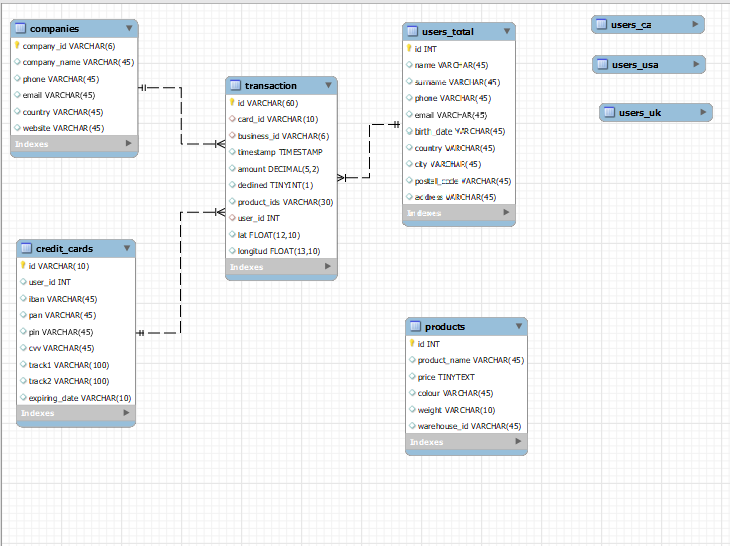



Exercici 1

Realitza una subconsulta que mostri tots els usuaris amb més de 30 transaccions utilitzant almenys 2 taules.

```
SELECT users_total.name, count(transaction.id) as NumTransactions
FROM users_total
JOIN transaction
On users_total.id=transaction.user_id
group by users_total.name
having count(transaction.id)>30;
```
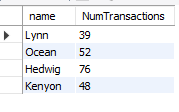


Exercici 2

Mostra la mitjana de la suma de transaccions per IBAN de les targetes de crèdit en la companyia Donec Ltd. utilitzant almenys 2 taules.

Considero que son dos transacciones, aunque una de ellas no se finalizó y la otra sí.

```
SELECT companies.company_name, credit_cards.iban, AVG(transaction.amount) as MediaTransaccion
FROM credit_cards
JOIN transaction
On credit_cards.id=transaction.card_id
JOIN companies
ON companies.company_id=transaction.business_id
WHERE companies.company_name = "Donec Ltd"
GROUP BY companies.company_name, credit_cards.iban;
```

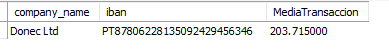




Nivell 2




Crea una nova taula que reflecteixi l'estat de les targetes de crèdit basat en si les últimes tres transaccions van ser declinades 

```
CREATE TABLE Estado_tarjetas
	SELECT CARD_ID,IF(SUM(DECLINED)=3,"INACTIVA","ACTIVA") AS ESTADO
	FROM  (
		SELECT CARD_ID, TIMESTAMP, DECLINED, 
		row_number() OVER(PARTITION BY CARD_ID ORDER BY TIMESTAMP DESC) AS FILA
		FROM transaction) AS NUEVATABLA
		WHERE FILA<=3
	GROUP BY CARD_ID
;
```


Exercici 1

Quantes targetes estan actives?

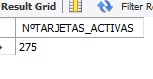



Nivell 3

Crea una taula amb la qual puguem unir les dades del nou arxiu products.csv amb la base de dades creada, tenint en compte que des de transaction tens product_ids.


Creando variable usuario @num
```
CREATE TABLE transactionNew
SELECT * ,
    @num := 1 + LENGTH(product_ids) - LENGTH(REPLACE(product_ids, ',', ''))              AS num,
    IF(@num >= 1, SUBSTRING_INDEX(product_ids, ',', 1), NULL)                           AS Pdt_id1,
    IF(@num > 1, SUBSTRING_INDEX(SUBSTRING_INDEX(product_ids, ',', 2), ',', -1), NULL) AS Pdt_id2,
    IF(@num > 2, SUBSTRING_INDEX(SUBSTRING_INDEX(product_ids, ',', 3), ',', -1), NULL) AS Pdt_id3,
    IF(@num > 3, SUBSTRING_INDEX(SUBSTRING_INDEX(product_ids, ',', 4), ',', -1), NULL) AS Pdt_id4
   FROM transaction;
   ```

Sin crear variable usuario @num
```
CREATE TABLE transactionNew
   SELECT * ,
     (1 + LENGTH(product_ids) - LENGTH(REPLACE(product_ids, ',', '')))              AS num,
    IF((1 + LENGTH(product_ids) - LENGTH(REPLACE(product_ids, ',', ''))) >= 1, SUBSTRING_INDEX(product_ids, ',', 1), NULL)                           AS Pdt_id1,
    IF((1 + LENGTH(product_ids) - LENGTH(REPLACE(product_ids, ',', '')))> 1, SUBSTRING_INDEX(SUBSTRING_INDEX(product_ids, ',', 2), ',', -1), NULL) AS Pdt_id2,
    IF((1 + LENGTH(product_ids) - LENGTH(REPLACE(product_ids, ',', ''))) > 2, SUBSTRING_INDEX(SUBSTRING_INDEX(product_ids, ',', 3), ',', -1), NULL) AS Pdt_id3,
    IF((1 + LENGTH(product_ids) - LENGTH(REPLACE(product_ids, ',', ''))) > 3, SUBSTRING_INDEX(SUBSTRING_INDEX(product_ids, ',', 4), ',', -1), NULL) AS Pdt_id4
   FROM transaction;
   ```

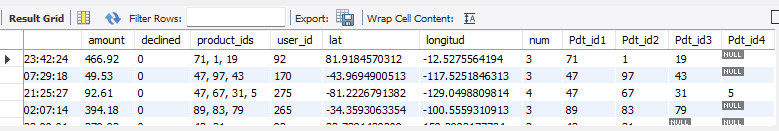


Creo las relaciones 4FK - PK entre las tablas transactionnew y products, y el resto de relaciones con las otras tablas.

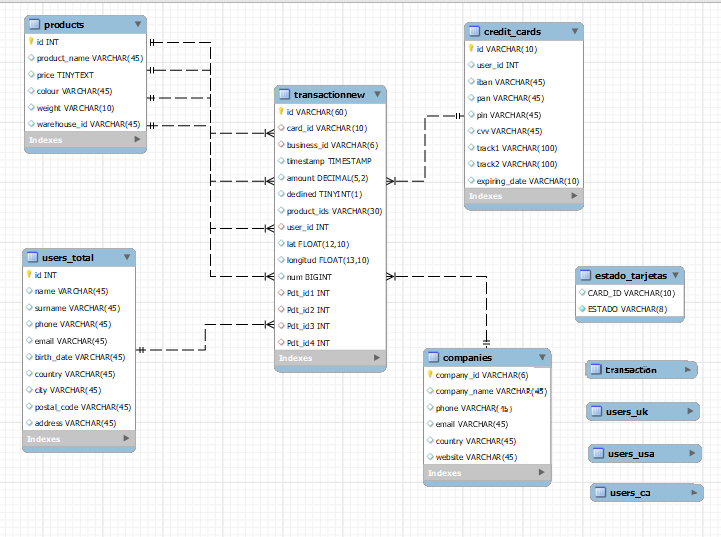


Exercici 1

Necessitem conèixer el nombre de vegades que s'ha venut cada producte.

```
SELECT PRODUCTOSVENDIDOS.IDPRODUCTO AS NºPRODUCTO, products.product_name ,COUNT(PRODUCTOSVENDIDOS.IDPRODUCTO) AS NºVECESCOMPRADO
FROM products
JOIN 
	(SELECT PDT_ID1 AS IDPRODUCTO FROM TRANSACTIONNEW
    UNION ALL
    SELECT PDT_ID2 AS IDPRODUCTO FROM TRANSACTIONNEW
    UNION ALL
    SELECT PDT_ID3 AS IDPRODUCTO FROM TRANSACTIONNEW
    UNION ALL
    SELECT PDT_ID4 AS IDPRODUCTO FROM TRANSACTIONNEW) AS PRODUCTOSVENDIDOS
ON products.id=productosvendidos.idproducto
WHERE 
	IDPRODUCTO IS NOT NULL
GROUP BY IDPRODUCTO;

```
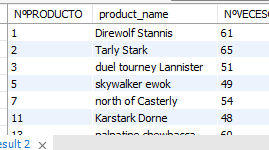
